In [1]:
# Import relevant packages
import gurobipy as gp                 # Gurobi Python API
from gurobipy import GRB              # Gurobi constants (e.g., GRB.MAXIMIZE)

import pandas as pd                   # DataFrames
import matplotlib.pyplot as plt       # Plotting
from matplotlib.lines import Line2D
import numpy as np                    # Numerical operations (similar to Julia base)

import warnings
warnings.filterwarnings("ignore", message=".*All values for SymLogScale are below linthresh.*")

In [2]:
from main import main

In [3]:
# --- Load data ---
def load_energinet_data(filepath):
    df = pd.read_csv(filepath, sep=';', decimal=',', parse_dates=['HourUTC'])
    # df = df.rename(columns=lambda x: x.strip())

    # Compute capacity factors
    df['CF_OffshoreWind'] = df['OffshoreWind_MWh'] / df['OffshoreWindCapacity']
    df['CF_OnshoreWind']  = df['OnshoreWind_MWh']  / df['OnshoreWindCapacity']
    df['CF_SolarPower']    = df['SolarPower_MWh']   / df['SolarPowerCapacity']

    # Convert timestamp
    df['HourUTC'] = pd.to_datetime(df['HourUTC'], dayfirst=True)
    df = df.sort_values('HourUTC')
    df['Year'] = df['HourUTC'].dt.year
    df['Month'] = df['HourUTC'].dt.month
    df['Season'] = df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                                     3: 'NA', 4: 'NA', 5: 'Summer',
                                     6: 'Summer', 7: 'Summer', 8: 'Summer',
                                     9: 'NA', 10: 'NA', 11: 'Winter'})
    df['Day'] = df['HourUTC'].dt.date
    df['HourOfYear'] = df['HourUTC'].dt.dayofyear * 24 + df['HourUTC'].dt.hour

    return df

# --- Plotting Functions ---
source_colors = {'OffshoreWind_MWh':'darkblue', 'OnshoreWind_MWh':'lightskyblue', 'SolarPower_MWh':'orange'}

def plot_timeseries(df, source_cols, title="Full Time Series", capacity_factors=False):
    fig, axs = plt.subplots(3,1,figsize=(8, 6), sharex=True, sharey=True)
    fig.suptitle(title)
    for col in source_cols:
        num = source_cols.index(col)
        if capacity_factors:
            col_cf = col.replace('_MWh', '')
            axs[num].plot(df['HourUTC'], df[f'CF_{col_cf}'], label=f'{col_cf} CF', color=source_colors[col])
            axs[num].set_ylabel('Hourly Capacity Factor')
        else:
            axs[num].plot(df['HourUTC'], df[col], label=col.replace('_MWh',''), color=source_colors[col])
            axs[num].set_ylabel('Production [MWh]')
        axs[num].legend(loc='upper left')
        axs[num].grid(True)

    plt.xlabel('Time')
    plt.tight_layout()
    suffix = '-cf' if capacity_factors else ''
    plt.savefig(f'res-generation{suffix}-time_series.pdf')
    plt.show()

def plot_yearly_series(df, year, source_cols, capacity_factors=False):
    fig, axs = plt.subplots(3,1,figsize=(10, 7), sharex=True, sharey=True)
    fig.suptitle(f"{year} Full Time Series")
    yearly = df[df['Year'] == year]
    for source in source_cols:
        num = source_cols.index(source)
        src = source.replace('_MWh', '')
        if capacity_factors:
            axs[num].plot(yearly['HourUTC'], yearly[f'CF_{src}'], label=f'{src} CF {year}', color=source_colors[source])
            axs[num].set_title(f'{src}')
            axs[1].set_ylabel('Hourly CF')
            fig.suptitle(f"{year} Full Time Series - Capacity Factor")
        else:
            axs[num].plot(yearly['HourUTC'], yearly[source], label=f'{src} {year}', color=source_colors[source])
            axs[num].set_title(f'{src} Production in {year}')
            axs[num].set_ylabel('MWh')
        axs[num].grid(True)
    plt.xlabel('Time')
    plt.tight_layout()
    plt.savefig(f'res-generation{year}-time_series.pdf')
    plt.show()

def plot_seasonal_series(df, source, medoid_days=None, capacity_factors=True):
    seasons = ['Winter', 'Summer']
    source_cf = source.replace('_MWh', '')
    for season in seasons:
        seasonal = df[df['Season'] == season]
        plt.figure(figsize=(12, 4))
        for day, subdf in seasonal.groupby('Day'):
            plt.plot(range(24), subdf[f'CF_{source_cf}'], color='gray', alpha=0.3)
        
        if medoid_days.any():
            for medoid_day in medoid_days:
                if pd.to_datetime(medoid_day).strftime('%Y-%m-%d') in seasonal['HourUTC'].dt.strftime('%Y-%m-%d').values:
                    medoid_df = seasonal[seasonal['Day'] == pd.to_datetime(medoid_day).date()]
                    plt.plot(range(24), medoid_df[f'CF_{source_cf}'], color='black', linewidth=2, label='Medoid')
        
        plt.title(f'{source.replace("_MWh", "")} - {season}')
        plt.xlabel('Time')
        plt.ylabel('MWh')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_medoids_per_season(df, source, medoid_days, capacity_factors=True):
    seasons = ['Winter', 'Summer']
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    axs = axs.flatten()

    for i, season in enumerate(seasons):
        ax = axs[i]
        j=0
        for medoid_day in medoid_days[season]:
            linestyles = ['-.','--', '-']
            medoid_day = pd.to_datetime(medoid_day).date()
            day_df = df[df['Day'] == medoid_day]
            col = f'CF_{source.replace("_MWh", "")}'
            ax.plot(range(24), day_df[col], color=source_colors[source], label=f'{medoid_day}', linewidth=2, linestyle=linestyles[j])
            j+=1

        ax.set_title(f"{source.replace('_MWh','')} CF - {season}")
        ax.set_xlabel('Hour')
        # ax.set_xticks(np.arange(0, 24, 2))
        if i % 2 == 0:
            ax.set_ylabel('Capacity Factor')
        ax.set_ylim(top=1, bottom=0)
        ax.grid(True)
        ax.legend(loc="upper left")

    # plt.suptitle(f"Representative Days per Season for {source.replace('_MWh','')}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f'{source}-medoids-profile.pdf')
    plt.show()

def plot_stacked_renewables(df):
    df_plot = df[['HourUTC', 'OffshoreWind_MWh', 'OnshoreWind_MWh', 'SolarPower_MWh']].copy()
    df_plot = df_plot.set_index('HourUTC')
    df_plot.columns = ['Offshore', 'Onshore', 'Solar']
    df_plot.plot.area(stacked=True, figsize=(14, 5), alpha=0.6, color=source_colors.values())
    plt.title("Stacked Renewable Generation")
    plt.ylabel("MWh")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



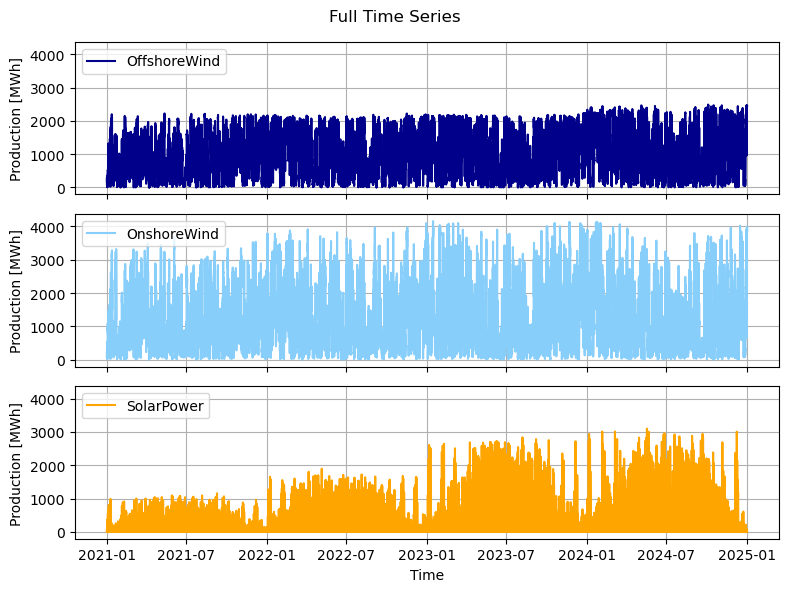

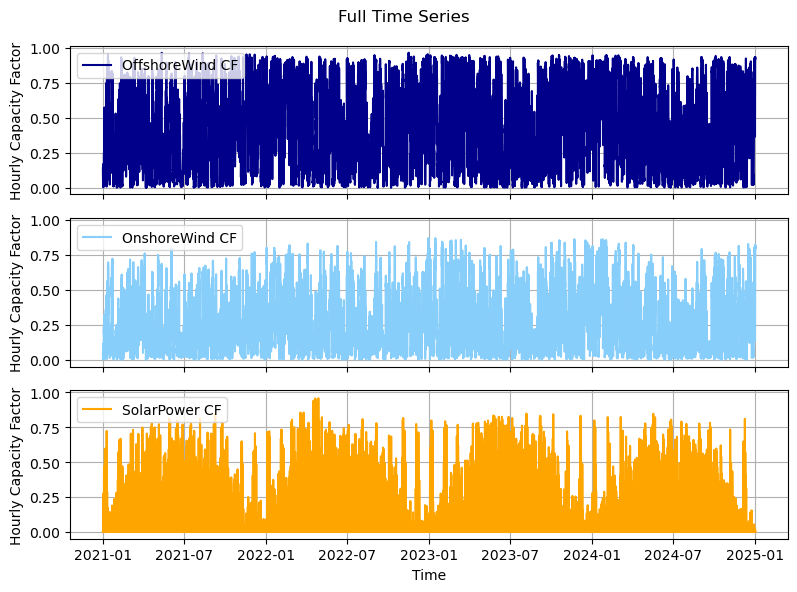

In [4]:
filepath = r"C:\Users\ppers\OneDrive\Documents\Cours DTU\MASTER THESIS\Codes\Master-thesis-code\data\RES\TimeSeries_2021-2024.csv"
df = load_energinet_data(filepath)

source_columns = ['OffshoreWind_MWh', 'OnshoreWind_MWh', 'SolarPower_MWh']
plot_timeseries(df, source_columns)
plot_timeseries(df, source_columns, capacity_factors=True)



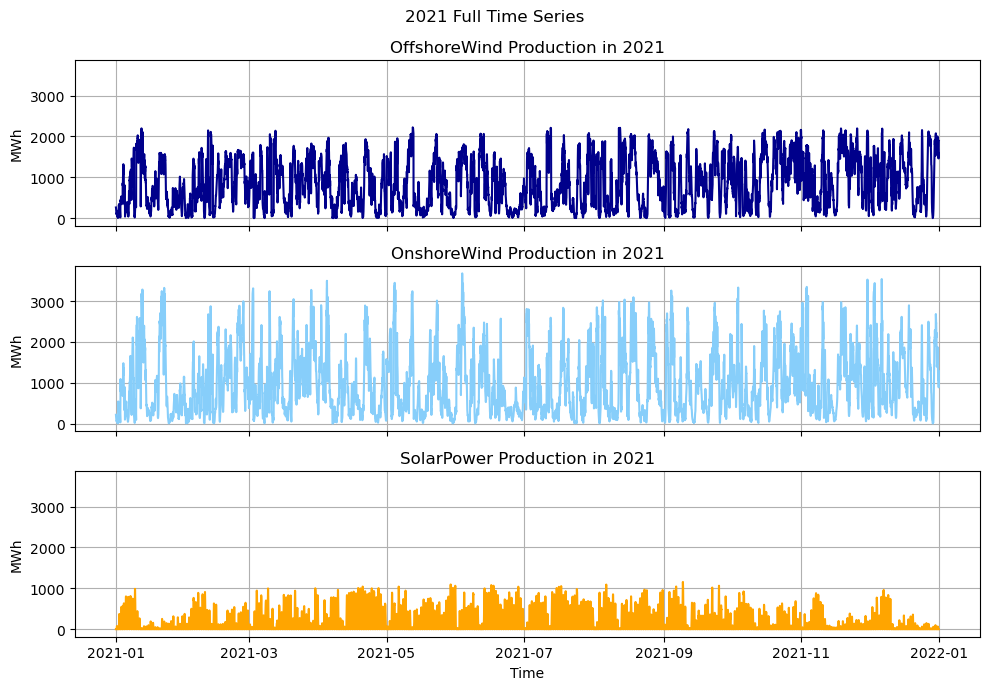

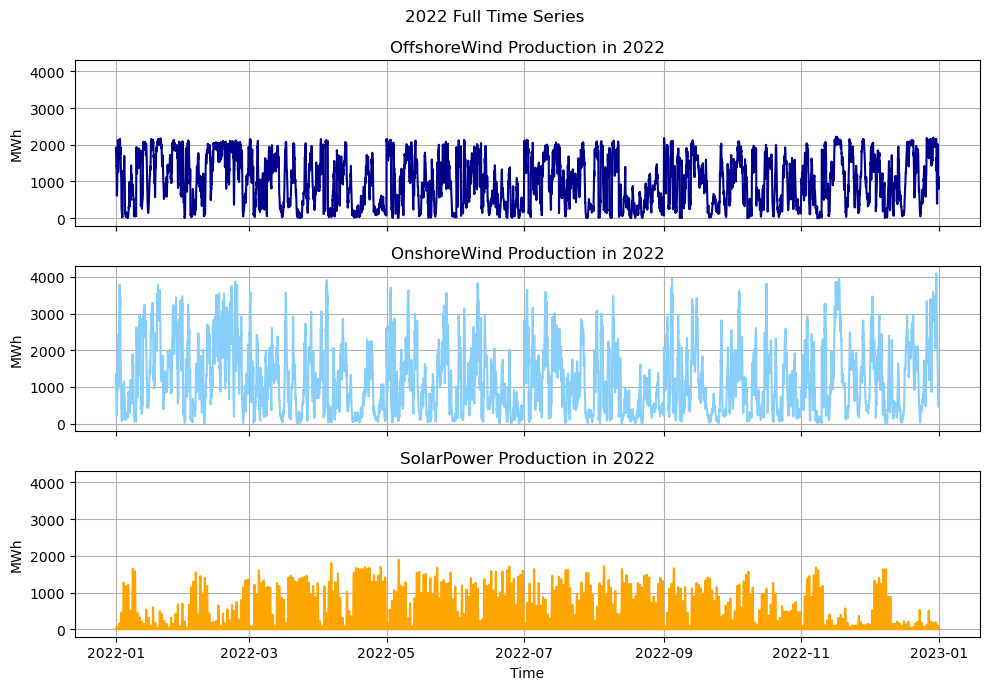

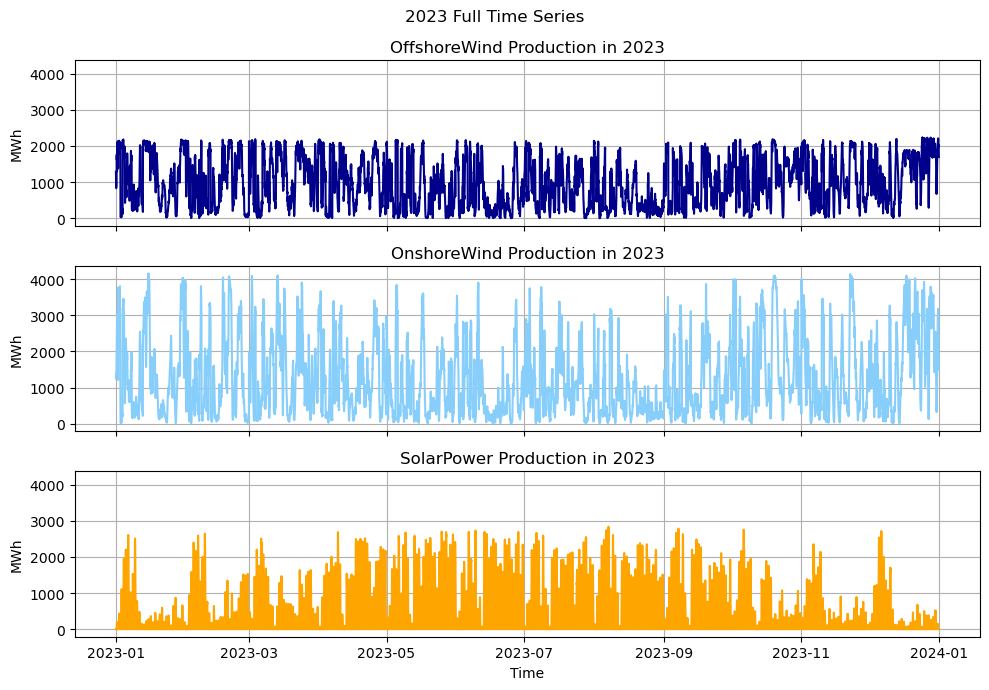

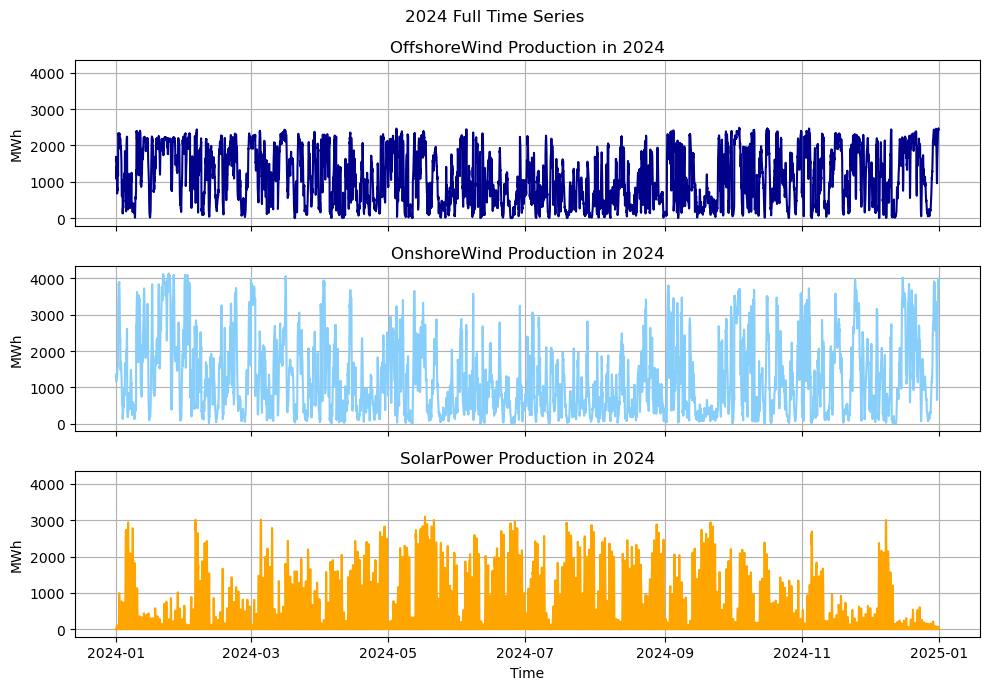

In [5]:
# Plot generation for each year and each renewable source
for year in sorted(df['Year'].unique()):
    plot_yearly_series(df, year, source_columns)

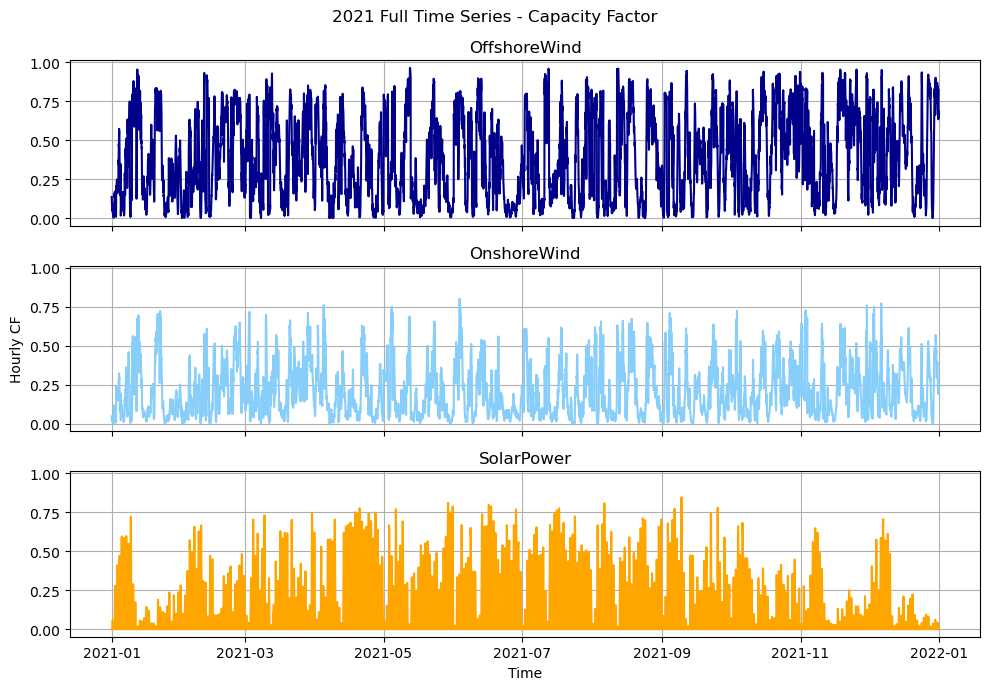

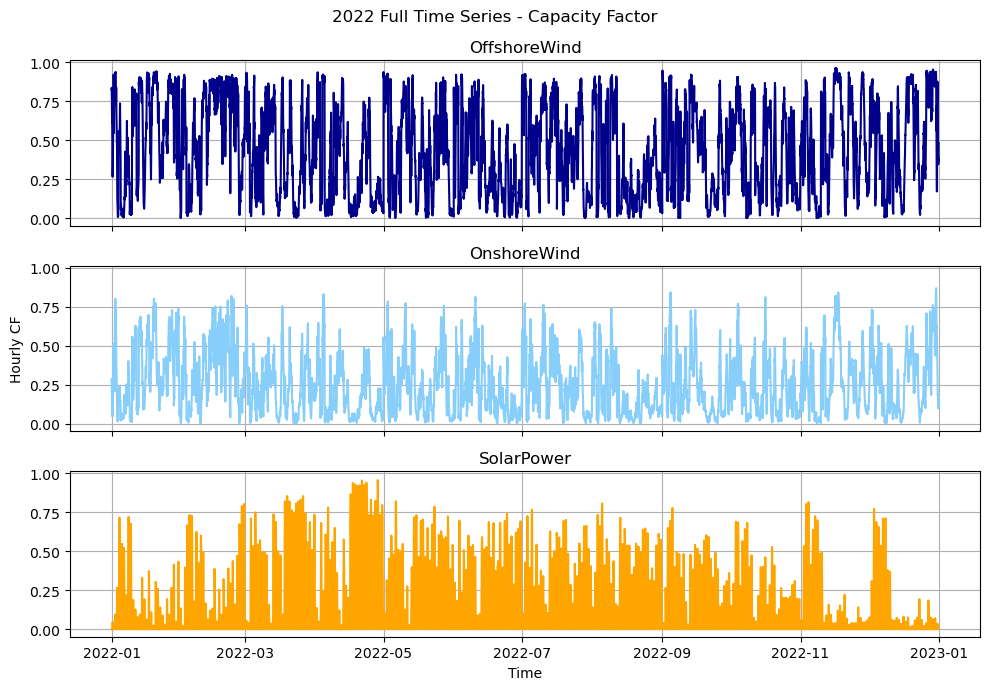

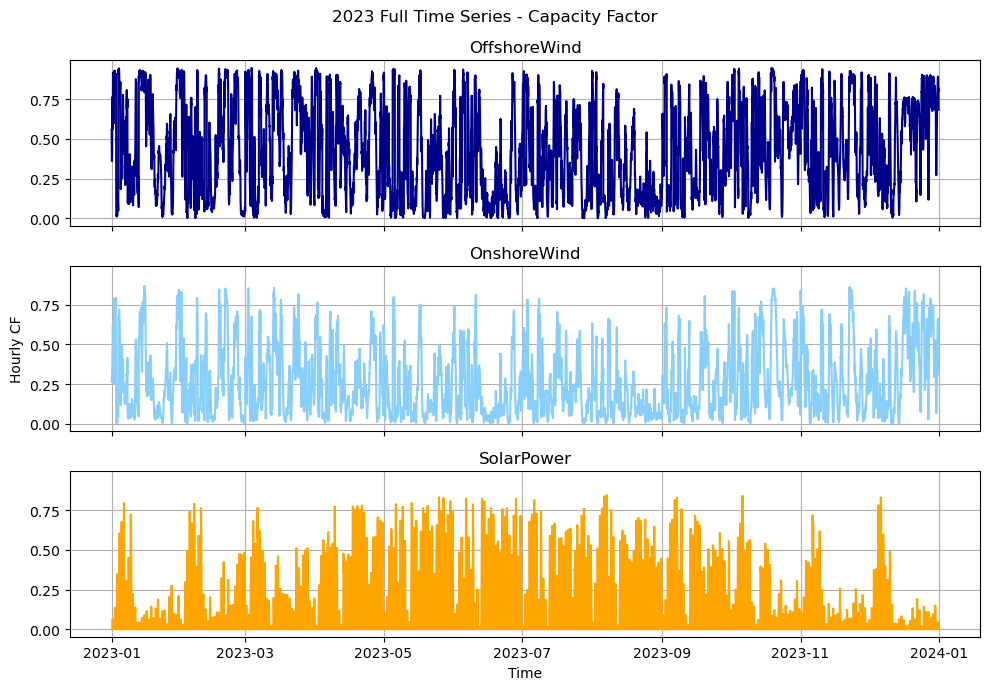

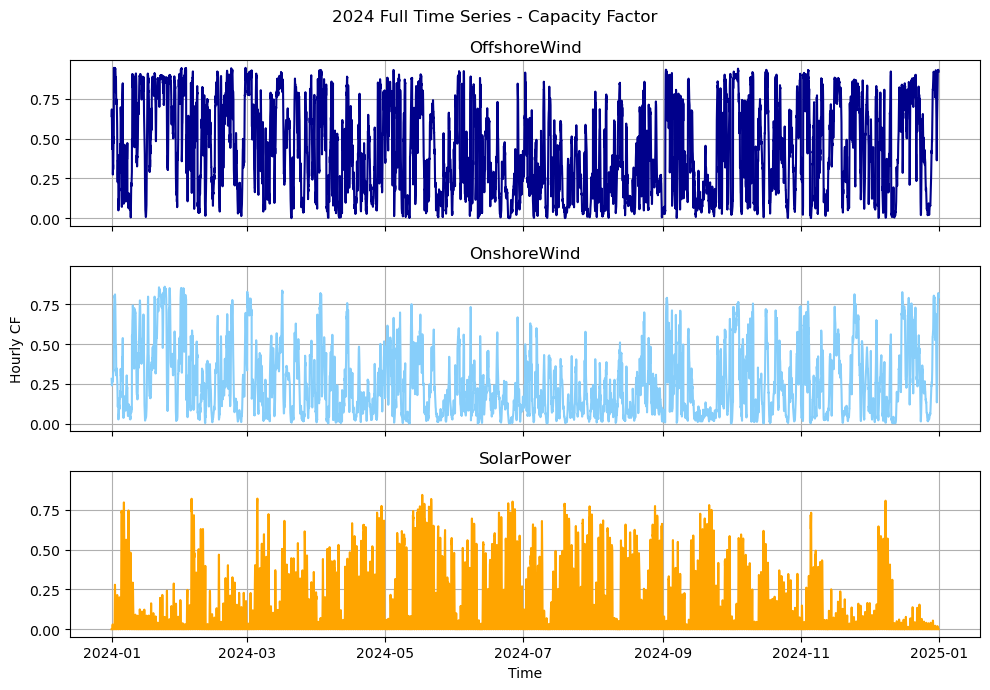

In [6]:
# Plot capacity factors for each year and each renewable source
for year in sorted(df['Year'].unique()):
    plot_yearly_series(df, year, source_columns, capacity_factors=True)

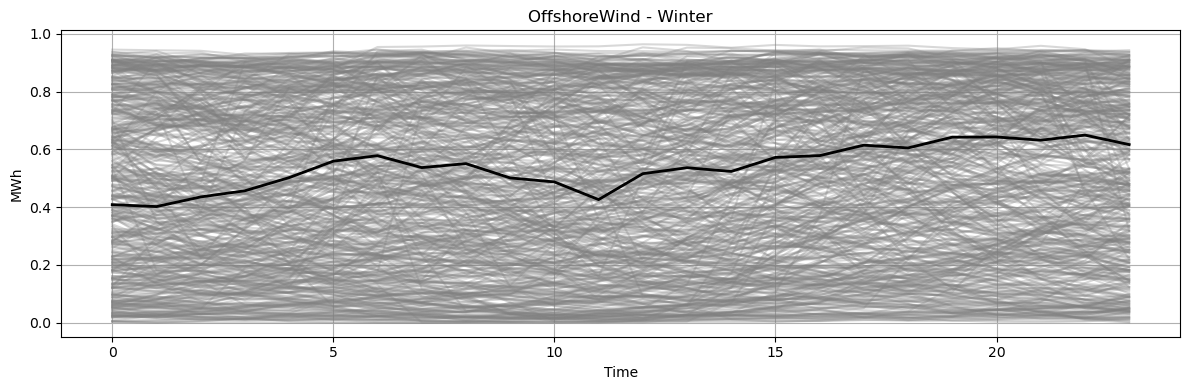

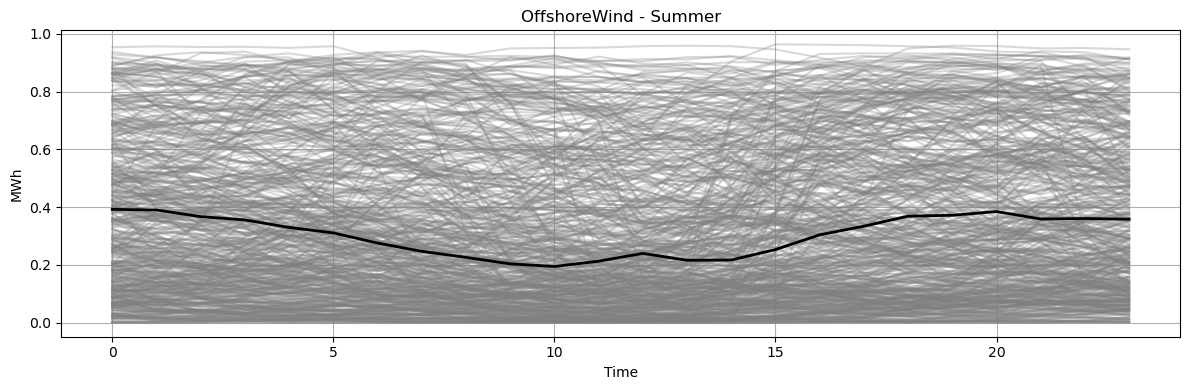

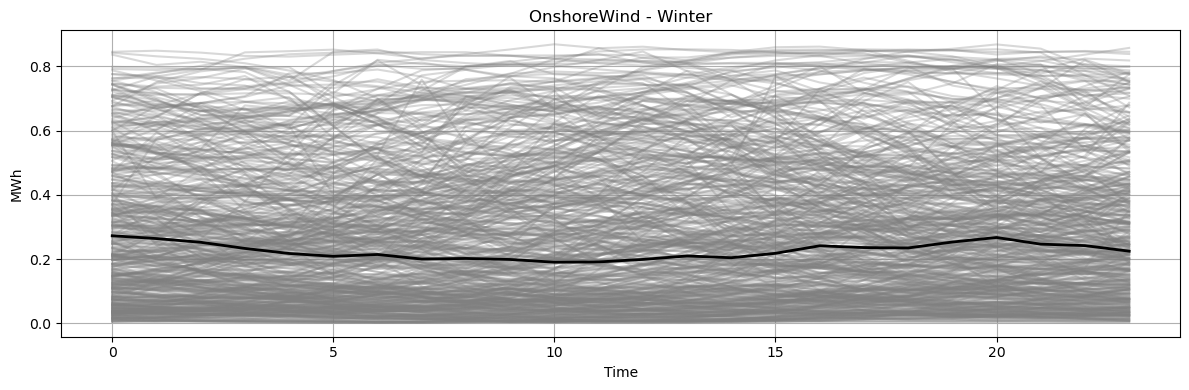

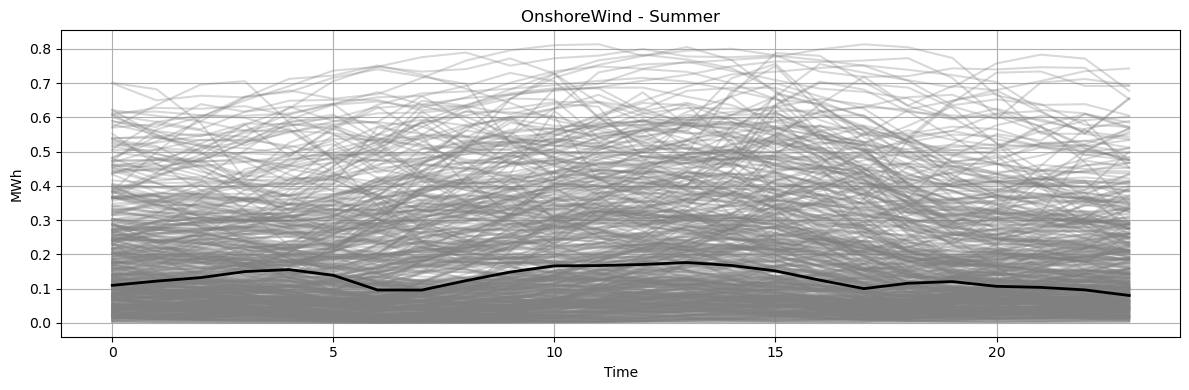

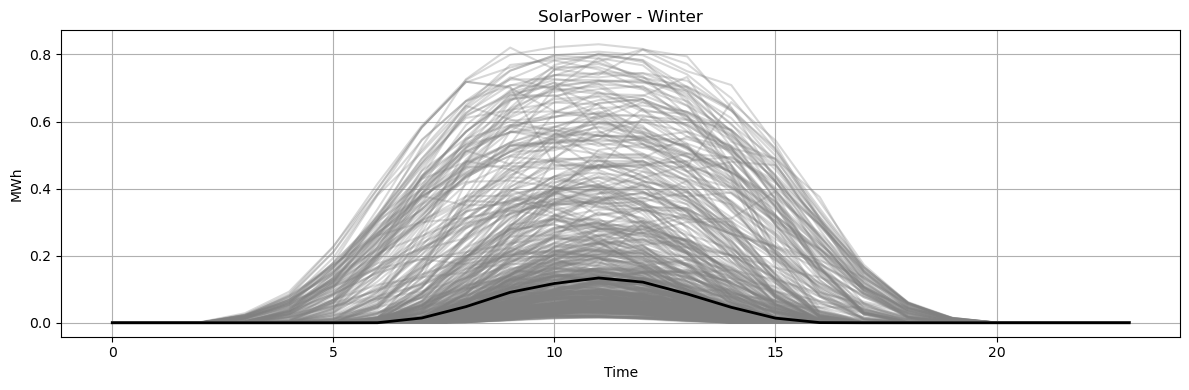

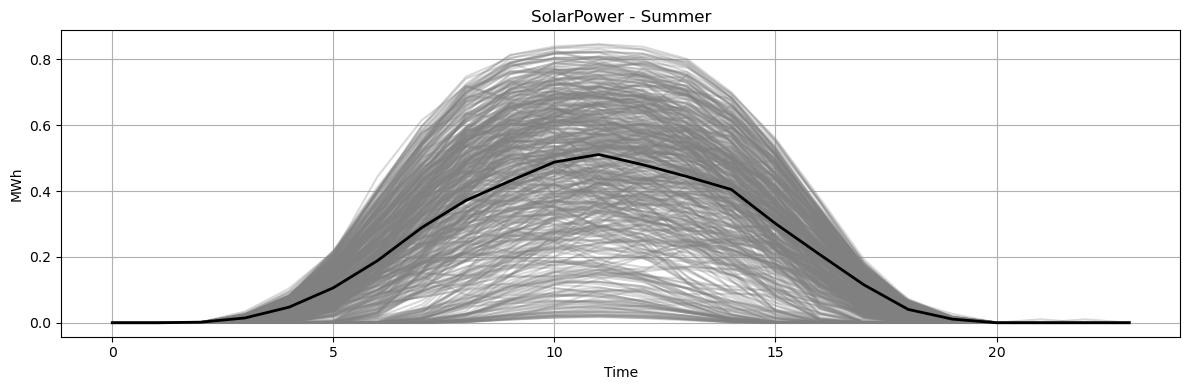

In [ ]:
# Plot medoids and corresponding time series for 1 cluster
medoids_filepath = r'C:\Users\ppers\OneDrive\Documents\Cours DTU\MASTER THESIS\Codes\Master-thesis-code\data\RES\extracted_csv-clusters\medoids_profile_summary--1cluster.csv'
medoids1_df = pd.read_csv(medoids_filepath)
medoids1_days = medoids1_df['Date'].to_numpy()

index = 0
for src in source_columns:
    plot_seasonal_series(df, src, medoids1_days[index:index+2])
    index += 2

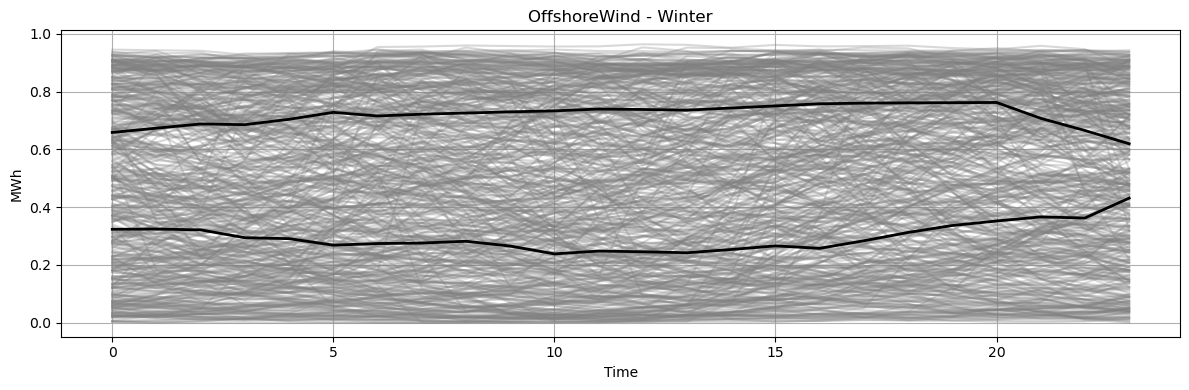

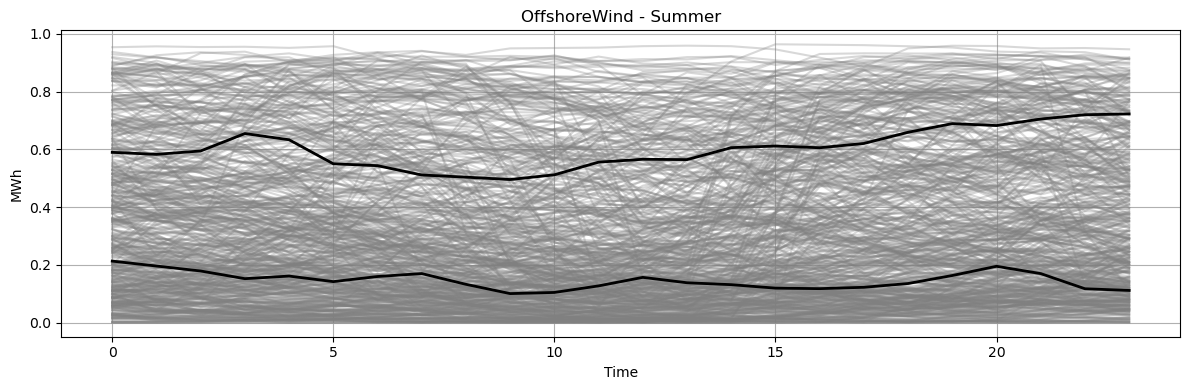

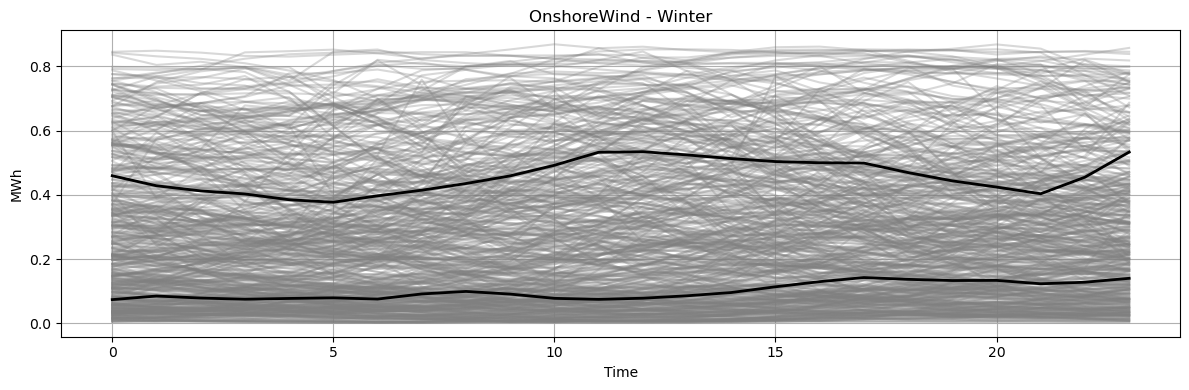

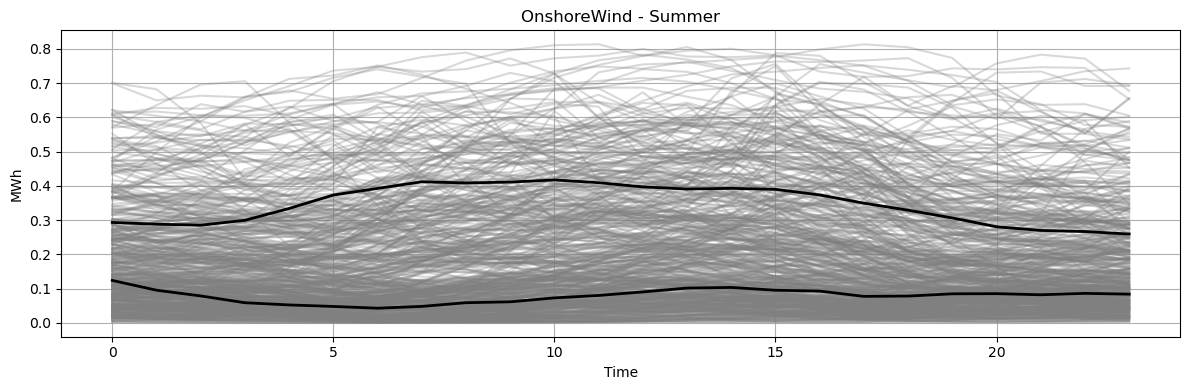

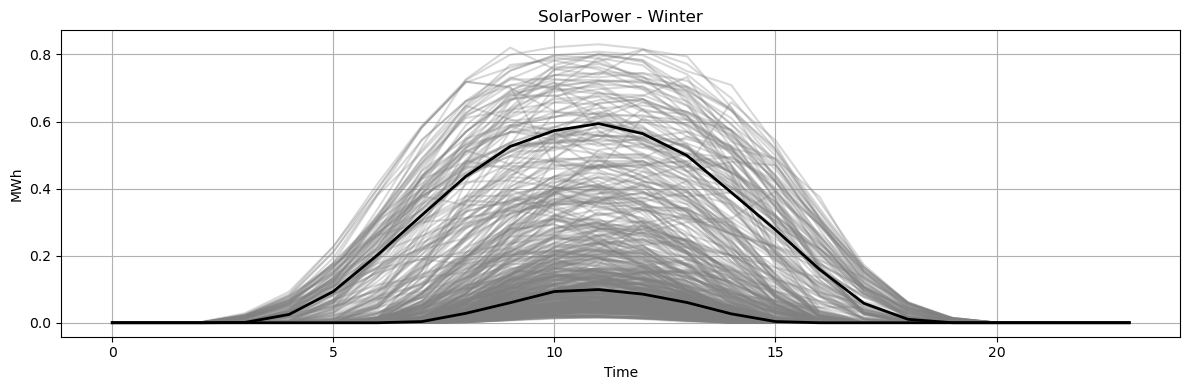

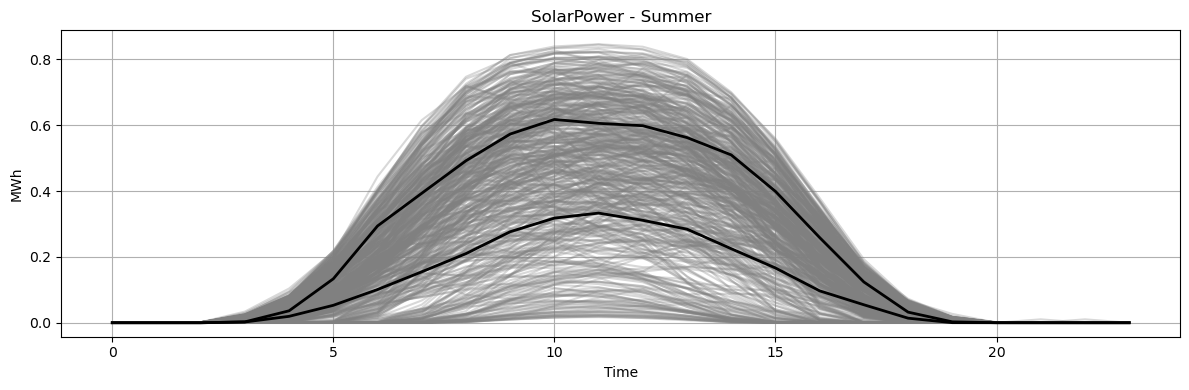

In [ ]:
# For 2 clusters
medoids_filepath = r'C:\Users\ppers\OneDrive\Documents\Cours DTU\MASTER THESIS\Codes\Master-thesis-code\data\RES\extracted_csv-clusters\medoids_profile_summary--2cluster.csv'
medoids2_df = pd.read_csv(medoids_filepath)
medoids2_days = medoids2_df['Date'].to_numpy()

index = 0
for src in source_columns:
    plot_seasonal_series(df, src, medoids2_days[index:index+4])
    index += 4

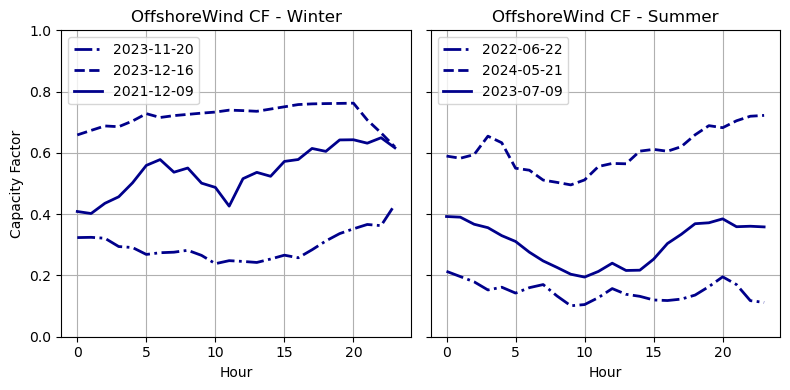

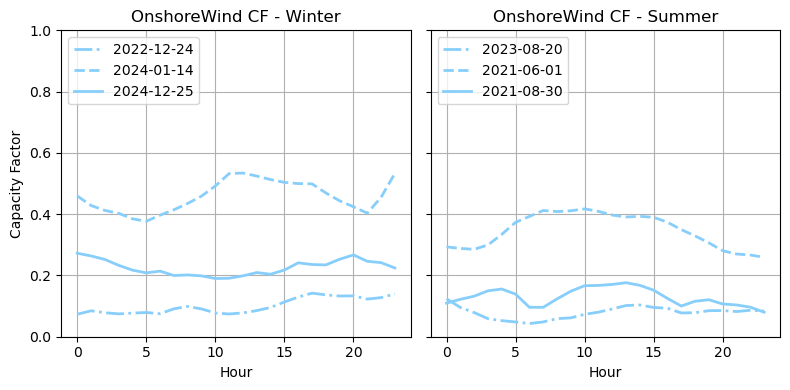

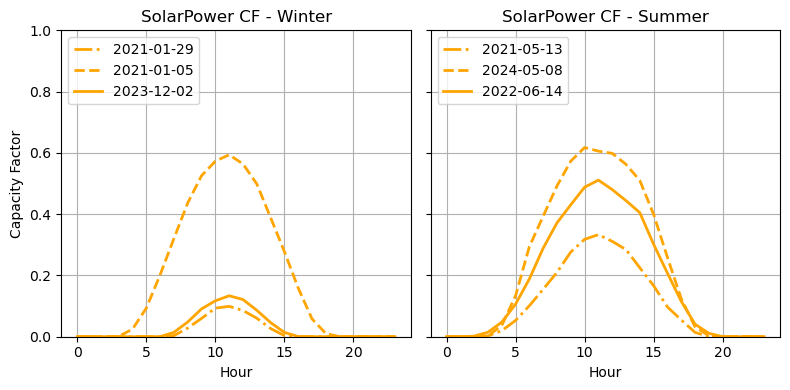

In [9]:
# For 2 clusters: plotting the medoids alone
medoids2_days[2], medoids2_days[3] = medoids2_days[3], medoids2_days[2]

index1 = 0
index2 = 0
for src in source_columns:
    plot_medoids_per_season(df, src, {'Winter': [med for med in medoids2_days[index2:index2+2]]+[medoids1_days[index1]], 'Summer': [med for med in medoids2_days[index2+2:index2+4]]+[medoids1_days[index1+1]]})
    index1 += 2
    index2 += 4

In [ ]:
clusters_filepath = r'C:\Users\ppers\OneDrive\Documents\Cours DTU\MASTER THESIS\Codes\Master-thesis-code\data\RES\extracted_csv-clusters\clusters_diagnostic_summary--2cluster.csv'
clusters_diagnostic = pd.read_csv(clusters_filepath)
print(clusters_diagnostic)

                     Cluster Medoid Date  Count  Proportion  Max Distance  \
0   Offshore Wind - Winter 0  2023-11-20    243        0.51      1.756261   
1   Offshore Wind - Winter 1  2023-12-16    238        0.49      1.987754   
2   Offshore Wind - Summer 0  2024-05-21    198        0.40      1.677761   
3   Offshore Wind - Summer 1  2022-06-22    294        0.60      1.942335   
4    Onshore Wind - Winter 0  2022-12-24    260        0.54      1.588397   
5    Onshore Wind - Winter 1  2024-01-14    221        0.46      1.826134   
6    Onshore Wind - Summer 0  2023-08-20    307        0.62      1.205201   
7    Onshore Wind - Summer 1  2021-06-01    185        0.38      1.694463   
8           Solar - Winter 0  2021-01-29    372        0.77      0.698626   
9           Solar - Winter 1  2021-01-05    109        0.23      0.857526   
10          Solar - Summer 0  2021-05-13    222        0.45      0.771653   
11          Solar - Summer 1  2024-05-08    270        0.55      0.681778   